In [1]:
from onnx_rec import *
from onnx_det import *

DetResizeForTest {'resize_long': 640}
NormalizeImage {'std': [1.0, 1.0, 1.0], 'mean': [0.48109378172549, 0.45752457890196, 0.40787054090196], 'scale': '1./255.', 'order': 'hwc'}
ToCHWImage {}
KeepKeys {'keep_keys': ['image', 'shape']}


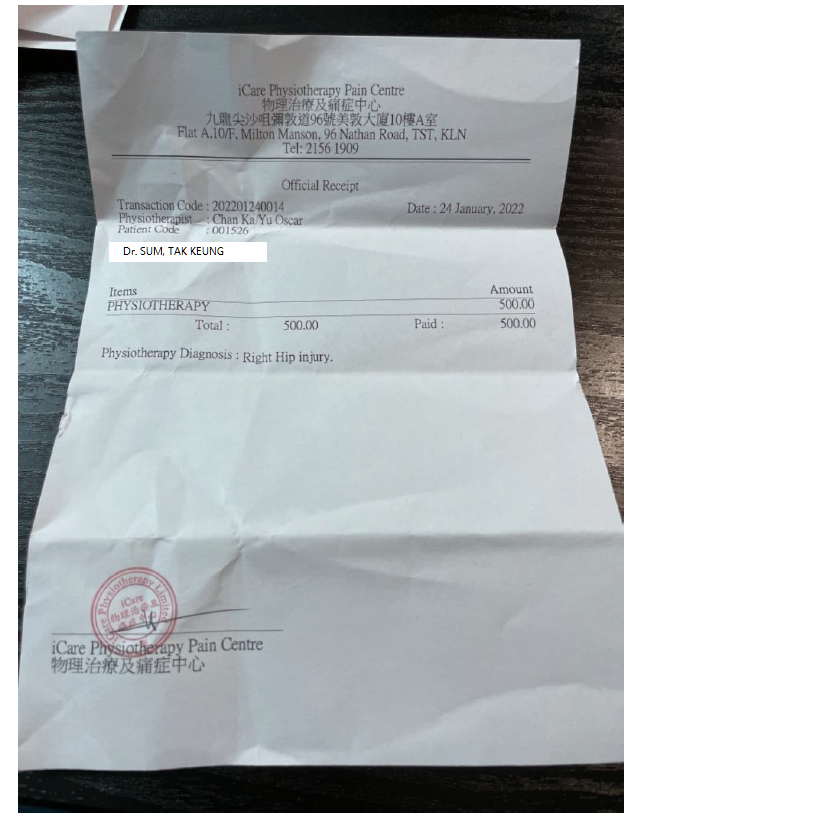

24

In [32]:
from PIL import Image
from IPython.display import display

det_db_thresh = 0.3
det_db_box_thresh = 0.3
max_candidates = 1000
unclip_ratio = 1.6
use_dilation = True
# DetResizeForTest 定义检测模型前处理规则

pre_process_list = [{
    'DetResizeForTest': {
        # 'limit_side_len': 2500,
        # 'limit_type': 'max',
        'resize_long': 640  # 512
        # 'image_shape':[640,640],
        # 'keep_ratio':True,
    }
}, {
    'NormalizeImage': {
        'std': [1.0, 1.0, 1.0],
        'mean':
            [0.48109378172549, 0.45752457890196, 0.40787054090196],
        'scale': '1./255.',
        'order': 'hwc'
    }
}, {
    'ToCHWImage': None
}, {
    'KeepKeys': {
        'keep_keys': ['image', 'shape']
    }
}]

preprocess = create_operators(pre_process_list)
postprocess = DBPostProcess(det_db_thresh, det_db_box_thresh, max_candidates, unclip_ratio, use_dilation)

model_path = 'models/model_det.onnx'
image_file = 'images/whole/203162_SP_1.png'

det_model = onnxruntime.InferenceSession(model_path, providers=['CPUExecutionProvider'])
img = cv2.imread(image_file)

display(Image.fromarray(img))

dt_boxes_part, img_part = get_boxes(img, det_model, preprocess, postprocess)
len(dt_boxes_part)

### init rec model

In [33]:
pred_process = RecPred('models/vocab.txt', 'ch', use_space_char=True)

svtr_path = 'models/svtr_small.onnx'
# OpenVINOExecutionProvider
# rec_model = InferenceSession(path, providers=['CUDAExecutionProvider'])
svtr_rec_model = InferenceSession(svtr_path, providers=['CPUExecutionProvider'])

crnn_path = 'models/latest_crnn.onnx'
# OpenVINOExecutionProvider
# rec_model = InferenceSession(path, providers=['CUDAExecutionProvider'])
crnn_rec_model = InferenceSession(crnn_path, providers=['CPUExecutionProvider'])

print(crnn_rec_model.get_providers())

# img_path = 'images/crop1.png'
# img = cv2.imread(img_path)

# print(onnx_rec_img_list([img,], rec_model, pred_process, padding=True, rec_image_shape=(3, 32, 400)))

['CPUExecutionProvider']


In [34]:
import copy
from PIL import Image
from IPython.display import display

img_list = []

for box in dt_boxes_part:
    tmp_box = copy.deepcopy(box)
    img_crop = get_rotate_crop_image(img, tmp_box)
    text, acc = onnx_rec_img(img_crop, svtr_rec_model, pred_process, padding=True, rec_image_shape=(3, 32, 400))
    if acc <= 0.93:
        text1, acc1 = onnx_rec_img(img_crop, crnn_rec_model, pred_process, padding=True, rec_image_shape=None)
        print(text1, acc1)
        if acc1 > acc:
            text, acc = text1, acc1
    print(text, acc)
    img_list.append(img_crop)
    display(Image.fromarray(img_crop))
    # print('*'*50)

len(img_list)

iCare Physiotherapy Pain Cente 0.9582718


物理治療及痛症中心 0.9997085


九龍尖沙咀彌敦道96號美敦大廈10樓A室 0.99641645


Flat A,10F,Milton Manson,9% Nathan Road, TST, KLN 0.94886
Flat A,10F,Milton Manson,9% Nathan Road, TST, KLN 0.94886


Tel: 2156 1909 0.97944415


Official Receipt 0.9999065


Transaction Code : 20220124014 0.94946784


Date : 24 January, 2022 0.99026424


Physiotherapist 0.9998763


Chan Ka Yu Oscar 0.9917803


Patient Code 0.9657824


: 001526 0.9387337


Dr. SUM, TAK KEUNG 0.99990124


Items 0.9995655


Amount 0.99995047


PHYSIOTHERAPY 0.99961936


500.00 0.9975973


Paid : 0.99909776


Total : 0.9637736


500.00 0.99931794


500.00 0.99984294


Physiotherapy Diagnosis : Right Hip injury 0.9801566


iCare Physiotherapy Pain Centre 0.985179


物理治療及痛症中心 0.99985206


24